In [ ]:
import torch
import torch.nn as nn

class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, features=[64, 128, 256, 512]):
        super(UNet, self).__init__()

        # Encoder: Downsampling path
        self.encoder = nn.ModuleList()
        for feature in features:
            self.encoder.append(self._block(in_channels, feature))
            in_channels = feature

        # Bottleneck
        self.bottleneck = self._block(features[-1], features[-1] * 2)

        # Decoder: Upsampling path
        self.decoder = nn.ModuleList()
        for feature in reversed(features):
            self.decoder.append(nn.ConvTranspose2d(feature * 2, feature, kernel_size=2, stride=2))
            self.decoder.append(self._block(feature * 2, feature))

        # Final output layer
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        # Encoder path
        skip_connections = []
        for layer in self.encoder:
            x = layer(x)
            skip_connections.append(x)
            x = nn.MaxPool2d(kernel_size=2, stride=2)(x)

        # Bottleneck
        x = self.bottleneck(x)

        # Reverse skip connections for decoder
        skip_connections = skip_connections[::-1]

        # Decoder path
        for idx in range(0, len(self.decoder), 2):
            x = self.decoder[idx](x)  # Transposed convolution (upsampling)
            skip_connection = skip_connections[idx // 2]

            # Handle mismatched dimensions
            if x.shape != skip_connection.shape:
                x = nn.functional.interpolate(x, size=skip_connection.shape[2:])

            # Concatenate skip connection
            x = torch.cat((skip_connection, x), dim=1)
            x = self.decoder[idx + 1](x)  # Convolution block

        return self.final_conv(x)

    @staticmethod
    def _block(in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        """Create a convolutional block with two Conv layers and ReLU activation."""
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )


In [ ]:
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os

class ImageDataset(Dataset):
    def __init__(self, lr_dir, hr_dir):
        self.lr_dir = lr_dir
        self.hr_dir = hr_dir
        self.lr_images = sorted(os.listdir(lr_dir))
        self.hr_images = sorted(os.listdir(hr_dir))

    def __len__(self):
        return len(self.lr_images)

    def __getitem__(self, idx):
        lr_image = Image.open(os.path.join(self.lr_dir, self.lr_images[idx]))
        hr_image = Image.open(os.path.join(self.hr_dir, self.hr_images[idx]))
        return ToTensor()(lr_image), ToTensor()(hr_image)

# Define dataset paths
train_lr_dir = "/content/drive/MyDrive/Digital Image Processing_Major Project/Split_Dataset/train_LR_degraded"
train_hr_dir = "/content/drive/MyDrive/Digital Image Processing_Major Project/Split_Dataset/train"
val_lr_dir = "/content/drive/MyDrive/Digital Image Processing_Major Project/Split_Dataset/validate_LR_degraded"
val_hr_dir = "/content/drive/MyDrive/Digital Image Processing_Major Project/Split_Dataset/validate"

# Create datasets and dataloaders
train_dataset = ImageDataset(train_lr_dir, train_hr_dir)
val_dataset = ImageDataset(val_lr_dir, val_hr_dir)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)


In [ ]:
from torchvision.transforms import Compose, ToTensor, Resize
from torch.utils.data import Dataset
from PIL import Image

class ImageDataset(Dataset):
    def __init__(self, lr_dir, hr_dir, target_size=(256, 256)):
        """
        Args:
            lr_dir (str): Directory for low-resolution images.
            hr_dir (str): Directory for high-resolution images.
            target_size (tuple): The target size for resizing images.
        """
        self.lr_dir = lr_dir
        self.hr_dir = hr_dir
        self.lr_images = sorted(os.listdir(lr_dir))
        self.hr_images = sorted(os.listdir(hr_dir))
        self.target_size = target_size
        self.transform = Compose([
            Resize(target_size),  # Resize images to the same size
            ToTensor(),           # Convert PIL image to tensor
        ])

    def __len__(self):
        return len(self.lr_images)

    def __getitem__(self, idx):
        lr_image = Image.open(os.path.join(self.lr_dir, self.lr_images[idx]))
        hr_image = Image.open(os.path.join(self.hr_dir, self.hr_images[idx]))
        lr_image = self.transform(lr_image)
        hr_image = self.transform(hr_image)
        return lr_image, hr_image


In [ ]:
# Define dataset paths
train_lr_dir = "/content/drive/MyDrive/Digital Image Processing_Major Project/Split_Dataset/train_LR_degraded"
train_hr_dir = "/content/drive/MyDrive/Digital Image Processing_Major Project/Split_Dataset/train"
val_lr_dir = "/content/drive/MyDrive/Digital Image Processing_Major Project/Split_Dataset/validate_LR_degraded"
val_hr_dir = "/content/drive/MyDrive/Digital Image Processing_Major Project/Split_Dataset/validate"

# Create datasets with resizing
train_dataset = ImageDataset(train_lr_dir, train_hr_dir, target_size=(256, 256))
val_dataset = ImageDataset(val_lr_dir, val_hr_dir, target_size=(256, 256))

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)


In [ ]:
import torch.optim as optim
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
import numpy as np

# Initialize model, loss function, and optimizer
model = UNet(in_channels=3, out_channels=3).cuda()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training parameters
num_epochs = 50
best_psnr = 0

# Training and validation loop
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for lr, hr in train_loader:
        lr, hr = lr.cuda(), hr.cuda()
        optimizer.zero_grad()
        outputs = model(lr)
        loss = criterion(outputs, hr)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # Validation
    model.eval()
    val_psnr = 0
    val_ssim = 0
    with torch.no_grad():
        for lr, hr in val_loader:
            lr, hr = lr.cuda(), hr.cuda()
            outputs = model(lr)

            # Convert tensors to NumPy arrays
            hr_np = hr.cpu().numpy()
            outputs_np = outputs.cpu().numpy()

            # Calculate PSNR
            val_psnr += psnr(hr_np, outputs_np, data_range=1)

            # Calculate SSIM with dynamic win_size
            for i in range(hr_np.shape[0]):  # Iterate over the batch
                h, w = hr_np[i].shape[1:3]
                win_size = min(7, h, w)  # Ensure win_size doesn't exceed image dimensions
                if win_size % 2 == 0:
                    win_size -= 1  # Ensure win_size is odd
                win_size = max(3, win_size)  # Ensure win_size is at least 3

                val_ssim += ssim(
                    hr_np[i].transpose(1, 2, 0),  # Convert (C, H, W) to (H, W, C)
                    outputs_np[i].transpose(1, 2, 0),
                    data_range=1,
                    win_size=win_size,
                    channel_axis=-1  # Specify the channel axis
                )

    # Average metrics across the validation dataset
    val_psnr /= len(val_loader)
    val_ssim /= len(val_loader.dataset)  # Normalize SSIM by the total number of images

    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {train_loss:.4f}, PSNR: {val_psnr:.2f}, SSIM: {val_ssim:.4f}")

    # Save the best model
    if val_psnr > best_psnr:
        best_psnr = val_psnr
        torch.save(model.state_dict(), "/content/best_unet_model.pth")
        print("Saved best model!")

print("Training complete!")


Epoch [1/50] - Train Loss: 5.5280, PSNR: 12.65, SSIM: 0.3746
Saved best model!
Epoch [2/50] - Train Loss: 0.6435, PSNR: 15.96, SSIM: 0.5664
Saved best model!
Epoch [3/50] - Train Loss: 0.2958, PSNR: 21.98, SSIM: 0.6521
Saved best model!
Epoch [4/50] - Train Loss: 0.2459, PSNR: 20.39, SSIM: 0.7079
Epoch [5/50] - Train Loss: 0.2046, PSNR: 23.64, SSIM: 0.7282
Saved best model!
Epoch [6/50] - Train Loss: 0.2046, PSNR: 21.76, SSIM: 0.7323
Epoch [7/50] - Train Loss: 0.1865, PSNR: 23.20, SSIM: 0.7449
Epoch [8/50] - Train Loss: 0.1830, PSNR: 24.46, SSIM: 0.7596
Saved best model!
Epoch [9/50] - Train Loss: 0.1764, PSNR: 23.36, SSIM: 0.7559
Epoch [10/50] - Train Loss: 0.1697, PSNR: 24.76, SSIM: 0.7782
Saved best model!
Epoch [11/50] - Train Loss: 0.1590, PSNR: 24.86, SSIM: 0.7808
Saved best model!
Epoch [12/50] - Train Loss: 0.1646, PSNR: 24.34, SSIM: 0.7766
Epoch [13/50] - Train Loss: 0.2169, PSNR: 24.19, SSIM: 0.7498
Epoch [14/50] - Train Loss: 0.1691, PSNR: 24.59, SSIM: 0.7855
Epoch [15/50] -

<ipython-input-10-8bd2e739e88e>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/content/best_unet_model.pth"))


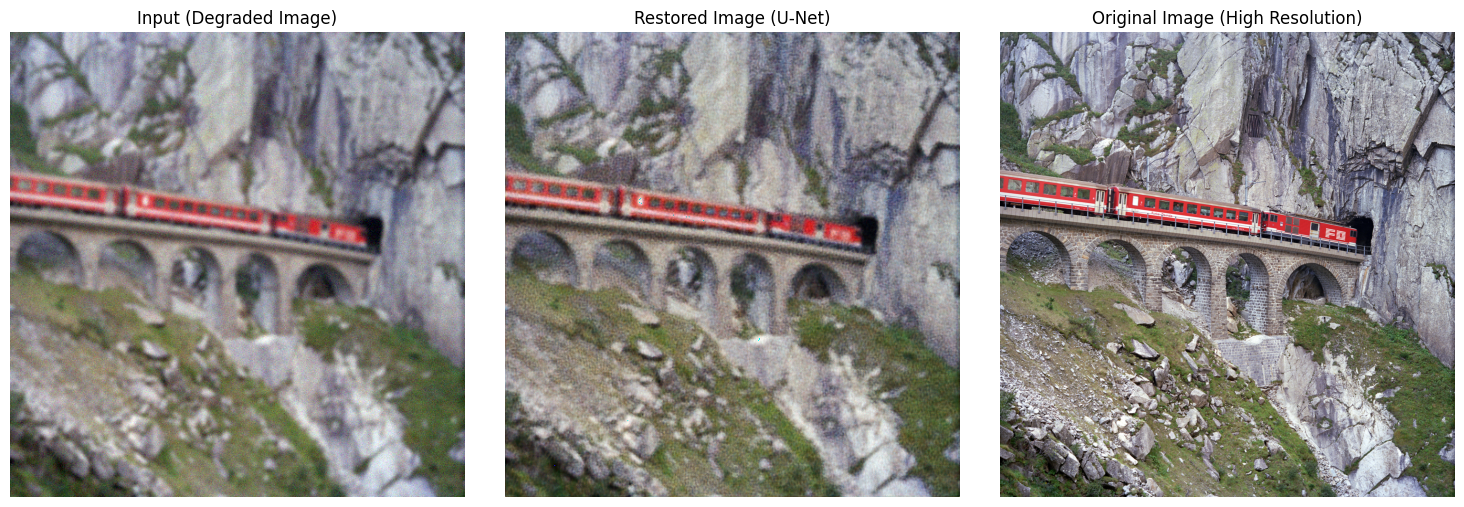

In [ ]:
# Load the best model
model.load_state_dict(torch.load("/content/best_unet_model.pth"))
model.eval()

# Define paths
test_lr_path = "/content/drive/MyDrive/Digital Image Processing_Major Project/Split_Dataset/test_LR_degraded/0545.png"
test_hr_path = "/content/drive/MyDrive/Digital Image Processing_Major Project/Split_Dataset/test/0545.png"

# Load images
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from PIL import Image

# Load input and original images
test_lr_image = ToTensor()(Image.open(test_lr_path)).unsqueeze(0).cuda()  # Input (Degraded)
test_hr_image = Image.open(test_hr_path)  # Ground truth (Original)

# Restore the image using U-Net
restored_image = model(test_lr_image).squeeze(0).cpu().detach().numpy()
restored_image = (restored_image * 255).astype(np.uint8).transpose(1, 2, 0)  # Convert to image format

# Convert low-resolution input to display format
input_image = Image.open(test_lr_path)

# Visualize Input, Restored, and Original images
plt.figure(figsize=(15, 5))

# Input Image (Degraded)
plt.subplot(1, 3, 1)
plt.title("Input (Degraded Image)")
plt.imshow(input_image)
plt.axis("off")

# Restored Image (Output from U-Net)
plt.subplot(1, 3, 2)
plt.title("Restored Image (U-Net)")
plt.imshow(restored_image)
plt.axis("off")

# Original Image (Ground Truth)
plt.subplot(1, 3, 3)
plt.title("Original Image (High Resolution)")
plt.imshow(test_hr_image)
plt.axis("off")

plt.tight_layout()
plt.show()


In [ ]:
pip install psnr


ERROR: Could not find a version that satisfies the requirement psnr (from versions: none)
ERROR: No matching distribution found for psnr


In [ ]:
import torch
import torch.nn as nn

class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, features=[64, 128, 256, 512]):
        super(UNet, self).__init__()

        # Encoder: Downsampling path
        self.encoder = nn.ModuleList()
        for feature in features:
            self.encoder.append(self._block(in_channels, feature))
            in_channels = feature

        # Bottleneck
        self.bottleneck = self._block(features[-1], features[-1] * 2)

        # Decoder: Upsampling path
        self.decoder = nn.ModuleList()
        for feature in reversed(features):
            self.decoder.append(nn.ConvTranspose2d(feature * 2, feature, kernel_size=2, stride=2))
            self.decoder.append(self._block(feature * 2, feature))

        # Final output layer
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        # Encoder path
        skip_connections = []
        for layer in self.encoder:
            x = layer(x)
            skip_connections.append(x)
            x = nn.MaxPool2d(kernel_size=2, stride=2)(x)

        # Bottleneck
        x = self.bottleneck(x)

        # Reverse skip connections for decoder
        skip_connections = skip_connections[::-1]

        # Decoder path
        for idx in range(0, len(self.decoder), 2):
            x = self.decoder[idx](x)  # Transposed convolution (upsampling)
            skip_connection = skip_connections[idx // 2]

            # Handle mismatched dimensions
            if x.shape != skip_connection.shape:
                x = nn.functional.interpolate(x, size=skip_connection.shape[2:])

            # Concatenate skip connection
            x = torch.cat((skip_connection, x), dim=1)
            x = self.decoder[idx + 1](x)  # Convolution block

        return self.final_conv(x)

    @staticmethod
    def _block(in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        """Create a convolutional block with two Conv layers and ReLU activation."""
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )


<ipython-input-25-22af0af19b56>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/content/best_unet_model.pth"))  # Ensure the path is corr

SSIM Calculation Error: win_size exceeds image extent. Either ensure that your images are at least 7x7; or pass win_size explicitly in the function call, with an odd value less than or equal to the smaller side of your images. If your images are multichannel (with color channels), set channel_axis to the axis number corresponding to the channels.
Metrics for Restored Image:
PSNR: 17.70
SSIM could not be calculated due to image size.


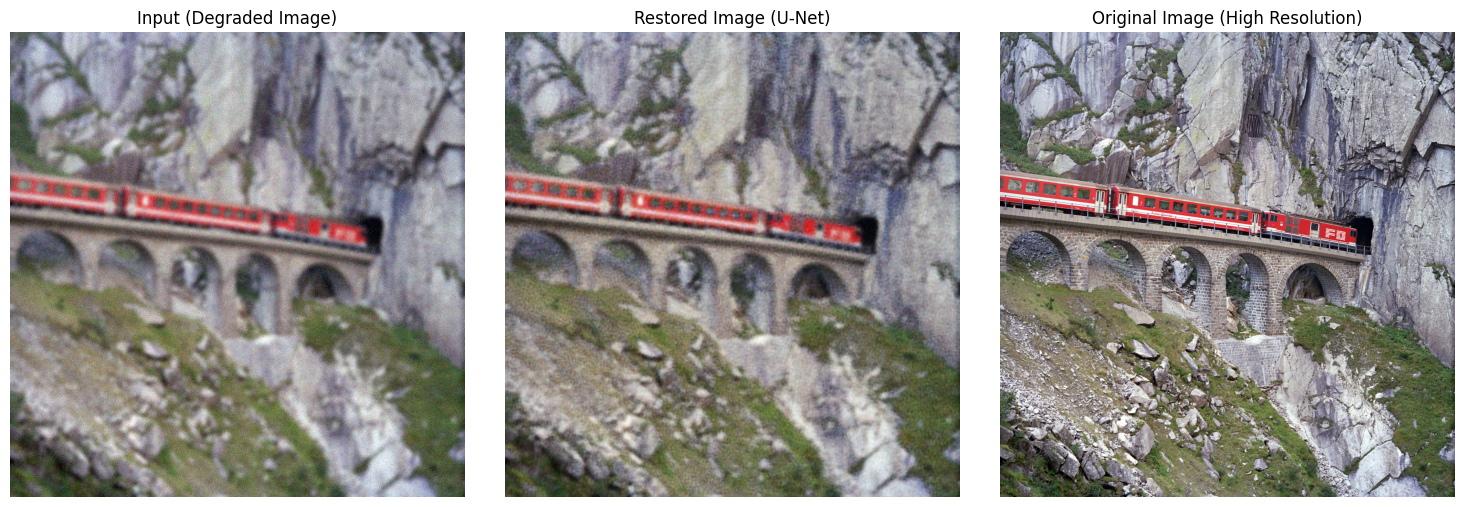

In [ ]:



# Load the trained model
model = UNet(in_channels=3, out_channels=3).cuda()
model.load_state_dict(torch.load("/content/best_unet_model.pth"))  # Ensure the path is correct
model.eval()

# Define paths for test images
test_lr_path = "/content/drive/MyDrive/Digital Image Processing_Major Project/Split_Dataset/test_LR_degraded/0545.png"
test_hr_path = "/content/drive/MyDrive/Digital Image Processing_Major Project/Split_Dataset/test/0545.png"

# Load images
test_lr_image = ToTensor()(Image.open(test_lr_path)).unsqueeze(0).cuda()  # Low-resolution input
test_hr_image = ToTensor()(Image.open(test_hr_path)).unsqueeze(0).cuda()  # High-resolution ground truth

# Restore the image using U-Net
restored_image = model(test_lr_image).detach().cpu().numpy().squeeze(0).transpose(1, 2, 0)  # Convert to (H, W, C)
test_hr_image_np = test_hr_image.detach().cpu().numpy().squeeze(0).transpose(1, 2, 0)       # Convert to (H, W, C)

# Resize restored image to match the ground truth
restored_image_resized = resize(
    restored_image,
    test_hr_image_np.shape[:2],  # Match height and width
    anti_aliasing=True
)

# Calculate PSNR
psnr_value = psnr(test_hr_image_np, restored_image_resized, data_range=1.0)

# Calculate SSIM with adjusted win_size
try:
    h, w = test_hr_image_np.shape[:2]
    win_size = min(7, h, w)  # Ensure win_size doesn't exceed dimensions
    if win_size % 2 == 0:
        win_size -= 1  # Ensure win_size is odd
    win_size = max(3, win_size)  # Ensure win_size is at least 3

    ssim_value = ssim(
        test_hr_image_np,
        restored_image_resized,
        multichannel=True,
        data_range=1.0,
        win_size=win_size
    )
except ValueError as e:
    print(f"SSIM Calculation Error: {e}")
    ssim_value = None  # Handle cases where SSIM cannot be computed

# Print metrics
print(f"Metrics for Restored Image:")
print(f"PSNR: {psnr_value:.2f}")
if ssim_value is not None:
    print(f"SSIM: {ssim_value:.4f}")
else:
    print("SSIM could not be calculated due to image size.")

# Visualize input, restored, and original images
input_image = Image.open(test_lr_path)
original_image = Image.open(test_hr_path)

plt.figure(figsize=(15, 5))

# Input Image (Degraded)
plt.subplot(1, 3, 1)
plt.title("Input (Degraded Image)")
plt.imshow(input_image)
plt.axis("off")

# Restored Image (Output from U-Net)
plt.subplot(1, 3, 2)
plt.title("Restored Image (U-Net)")
plt.imshow(restored_image_resized)
plt.axis("off")

# Original Image (High Resolution)
plt.subplot(1, 3, 3)
plt.title("Original Image (High Resolution)")
plt.imshow(original_image)
plt.axis("off")

plt.tight_layout()
plt.show()


In [ ]:
# Load the trained model
state_dict = torch.load("/content/best_unet_model.pth", weights_only=True)
model.load_state_dict(state_dict)
model.eval()

# SSIM with fixed win_size
try:
    ssim_value = ssim(
        test_hr_image_np,
        restored_image_resized,
        multichannel=True,
        data_range=1.0,
        win_size=3  # Explicitly set win_size to handle small images
    )
except ValueError as e:
    print(f"SSIM Calculation Error: {e}")
    ssim_value = None

# Normalize image for visualization
restored_image_resized = np.clip(restored_image_resized, 0, 1)  # Ensure valid pixel range

# Print metrics
print(f"Metrics for Restored Image:")
print(f"PSNR: {psnr_value:.2f}")
if ssim_value is not None:
    print(f"SSIM: {ssim_value:.4f}")
else:
    print("SSIM could not be calculated due to image size.")


Metrics for Restored Image:
PSNR: 17.70
SSIM: 0.4017
